# Computer vision notebook

## 0. Goal and résumé


## 1. Set-up

Houses are represented by red shapes, grass by green shapes, the neighbourhood is white, and our thymio is in dark blue. We added a white obstacle (which is the box of the Thymio) that will not be seen by the camera to see how the Thymio handle it on is own.

<img src="Thymio_images/raw_map.jpg" alt="Drawing" style="width: 400px;"/>

## 2. Computer vision

### Libraries
Using OpenCV and Shapely libraries, we get a livestream from the webcam and we use the first frame of the video to detect most of the things that we need to plan the navigation of the robot (see sect ------). 

In [1]:
from math import pi
import numpy as np 
from cv2 import cv2 as cv
from matplotlib import pyplot as plt
from shapely.geometry import MultiPolygon, Polygon 
from shapely.geometry import LineString, Point

### Colour detection and colour space
All object detection made during this project is based on colour segmentation, for a matter of simplicity. We first used the default colour space of OpenCv which is BGR to choose ranges used to detect the objects, but these ranges were very sensible to lightning, and the computer vision was not always accurate, so we searched for a colour space suiting better our purpose. BGR colour space is bad for our task because we want to separate chromatic information (Is it red? blue?) and brightness. We found that the HSV (Hue, Saturation, Value) colour space was good for that purpose and OpenCv provides a simple function for converting from one colour space to the other.[1]

Colour frames have some random variations in brightness or hue among pixels. So, to have a better detection of colours, we first blurred the image to have less noise using gaussian blur.  
We used masks to isolate every needed colour, then, we obtained the contours of the detected objects. We applied an area threshold to be sure to detect only significant objects. 


In [2]:
def get_color_contour(frame, color):
    if color == "white":
        lower_color = np.array([0,0,128]) 
        upper_color = np.array([179,46,247]) 
    elif color == "blue":
        lower_color = np.array([96,63,62]) 
        upper_color = np.array([130,255,255])
    elif color == "red":
        lower_color = np.array([130,100,100]) 
        upper_color = np.array([179,255,255])
    elif color == "green":
        lower_color = np.array([45,60,0])
        upper_color = np.array([90,140,140])
    else:
        return [0]
    frame = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    mask_white = cv.inRange(frame, lower_color, upper_color)
    contours, _= cv.findContours(mask_white, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    
    return contours


### Planar geometry
To prepare the visibility graph used for navigation, we used a planar geometry library: Shapely [3]. We approximated every contour by a polygon using the function approxPolyDP function from OpenCv. For the epsilon parameter, which represents the maximum distance between the original curve and the approximation, we set a number depending on the perimeter of the contour, which was found to do quite good approximations. This means the smaller the obstacle, the more the approximation will try to be precise. Then we used the buffer function from Shapely to get an approximate representation of all the points at a distance equal to the radius of the smallest circle fitting the robot of the polygon approximate of the contour of the obstacles and map. This allowed us to consider the robot as a point, being sure that it would not touch obstacles or leave the map.

### Detecting the map
The map is defined as the biggest white contour based on area. By definition, there is only one map. The frame to display is resized based on the smallest rectangle containing this contour. The map is dilated towards its interior by the radius of the robot to ensure that it stay in the map.

In [3]:
def polygon(c):
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.005 * peri, True)
    
    return approx

def cam_get_bounded_frame(frame, show_contour = False, show_polygone = False):
    contours_white = get_color_contour(frame, "white")

    if contours_white: #if list is not empty
        contour = max(contours_white, key = cv.contourArea)
        #print(contour)
    else:
        contour = [[0,0],[1,0]]
    x_rect,y_rect,w_rect,h_rect = cv.boundingRect(contour)

    frame_limits = [y_rect, y_rect+h_rect, x_rect, x_rect+w_rect] #min_y, max_y, min_x, max_x

    contour = contour-[x_rect,y_rect]

    if show_contour:
        cv.drawContours(frame[frame_limits[0]: frame_limits[1], frame_limits[2]: frame_limits[3]], contour, -1, (255,255,255),3)
    
    if show_polygone:
        white_pts = np.squeeze(polygon(contour))
        draw_polygone(frame, white_pts, "white")

    return frame_limits, contour

def cam_get_contour(map_contour, radius):
    map_contour_poly = Polygon(np.squeeze(polygon(map_contour)))
    dilated_map = map_contour_poly.buffer(-radius, join_style=2,single_sided=True)
    return map_contour_poly, dilated_map

### Detecting Santo (Thymio robot)
The pose of the robot is defined as being the center of the smallest circle enclosing the robot. We also use the diameter of this circle in pixels to get a scale from pixels to millimeters (we measured the diagonal of the robot as being 140mm which represents two radii). We also use the smallest rectangle enclosing the robot to get the angle of the robot.

In [4]:
def cam_locate_thymio(frame, show_contour = False, show_circle = False):
    contours_blue = get_color_contour(frame, "blue")

    max_blue_area = 0
    thymio_pos = [0,0]
    thymio_angle = 0.0
    scale_mm = 1
    radius = 1
    blue_zones_counter = 0
    for contour_blue in contours_blue:
        area = cv.contourArea(contour_blue)
        if area > 1000 and area > max_blue_area:
            blue_zones_counter += 1
            max_blue_area = area
            (x,y),radius = cv.minEnclosingCircle(contour_blue)
            (rect_cent, (rect_width, rect_height), rect_angle) = cv.minAreaRect(contour_blue)
            center = (int(x),int(y))
            scale_mm = 140/(2*radius)
            radius = int(radius)
            thymio_pos = center
            if show_contour:
                cv.drawContours(frame, contour_blue, -1, (255,0,0),3)
            if show_circle:
                cv.circle(frame,center,radius,(255,0,0),2)
                cv.circle(frame, center, 7, (255, 0, 0), -1)
                box = cv.boxPoints((rect_cent, (rect_width, rect_height), rect_angle))
                box_points = list((int(point[0]),int(point[1])) for point in box)
                draw_polygone(frame,box_points,"blue")
            #takes the angle from the rectangle framing the thymio that is the closest to the noisy angle
            noisy_angle = np.arctan2(center[1] - rect_cent[1],rect_cent[0] - center[0]) #is in rad
            possible_angles = np.array(list((-rect_angle + s*90.)*pi/180. for s in range(4)))
            angles_errors = list(abs(np.arctan2(np.sin(noisy_angle - poss_angle), np.cos(noisy_angle - poss_angle))) for poss_angle in possible_angles)
            thymio_angle = possible_angles[np.argmin(angles_errors)]
    thymio_visible = True

    if blue_zones_counter == 0:
        thymio_visible = False

    return thymio_pos, thymio_angle, thymio_visible, radius, scale_mm


def convert_to_mm(y_axis_size, scale, coords_px):
    return [coords_px[0]*scale, (y_axis_size-coords_px[1])*scale]

def convert_to_px(y_axis_size, scale, coords_mm):
    return [int(coords_mm[0]/scale), int(y_axis_size-coords_mm[1]/scale)]

### Detecting the houses (targets)

Targets are not defined as polygons but as points. The goal of the Thymio is to reach their centroids which we computed using the moments function from OpenCv. We also only consider the targets that are in the dilated map and outside of the dilated polygons.

In [5]:
def cam_get_targets(frame, show_contour = False, show_center = False):
    contours_red = get_color_contour(frame, "red")

    target_list = []
    for contour_red in contours_red:
        area = cv.contourArea(contour_red)
        if area > 1000:
            M = cv.moments(contour_red)
            if M['m00'] != 0:
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
                target_list.append((cx,cy))
            if show_contour:
                cv.drawContours(frame, contour_red, -1, (0,0,255),3)
            if show_center:
                cv.circle(frame, (cx, cy), 7, (0,0,255), -1)

    return target_list

def reachable_targets(targets_list,dilated_map,dilated_obstacle_list):
    for target in targets_list:
        if not Point(target).within(dilated_map):
            targets_list.remove(target)
        else:
            for x in dilated_obstacle_list:
                 if Point(target).within(x):
                    targets_list.remove(target)

    return targets_list

### Detecting the obstacles
As for the map, we get all the contours, and we dilate them by the radius of the robot this time, in the exterior direction.

In [6]:
def cam_get_obstacles(frame, radius, show_contour = False, show_polygone = False):
    contours_green = get_color_contour(frame, "green")

    area_obstacles = MultiPolygon()
    dilated_obstacle_list = []
    for contour_green in contours_green:
        area = cv.contourArea(contour_green)
        if area > 1000:
            pts = np.squeeze(polygon(contour_green))
            pol = Polygon(pts)
            dilated_obstacle = pol.buffer(radius, join_style=2 ,single_sided=True)
            dilated_obstacle_list.append(dilated_obstacle)
            area_obstacles = area_obstacles.union(dilated_obstacle)
            if show_contour:
                cv.drawContours(frame, contour_green, -1, (0,255,0),3)
            if show_polygone:
                draw_polygone(frame, pts, "green")

    obstacles_boundary = []

    if type(area_obstacles) != Polygon:
        for geom in area_obstacles.geoms:    
            xo, yo = geom.exterior.xy
            obstacles_boundary.append(zip(xo,yo))

    obstacles_list = []
    for obstacle in obstacles_boundary :
        obstacles_list.append(list(obstacle))

    return obstacles_list, dilated_obstacle_list

### Visibility graph
We decided to use a visibility graph, because it allows us to get the shortest path in Euclidean distance, and it is quite easy to implement since the camera can localize all the obstacles, targets, and Santo at the start. 

We used a dictionary to store, for each vertex ( Thymio and targets centroids, vertices of the polygon approximation of the obstacles), the points that are reachable by following a simple line on the map, checking if the line linking the two vertices is on the map and does not go through an obstacle. Using this visibility graph, we have been able to determine the path for which the Thymio covers the smallest distance possible while going to every target. Better solutions exist taking into account the computational time, but for our application, we didn't need to make the program faster so we sticked to the easiest solution which is effective.


In [7]:
def visible(a,b, polygon_obstacle, polygon_map):
    visible = 1
    line = LineString([a,b])
    for x in polygon_obstacle:
        within_obstacle = line.within(x)
        crosses_obstacle = line.crosses(x)
        if within_obstacle == True or crosses_obstacle == True:
            visible = False     
    in_map = polygon_map.contains(line)
    if in_map == False:
        visible = False
    return visible

def distance(a,b):
    dist = np.linalg.norm(np.array(a)-np.array(b))
    return(dist)    

# Returns dictionnary containing for the key the index of the vertex of interest 
# and for the value, other vertices with distance that are valid paths for the robot
def vis_graph(start,targets,obstacles,polygon_obstacle,polygon_map):
    graph = {}
    start_idx = 0
    obstacles = [item for sublist in obstacles for item in sublist]
    targets_idx_list = list(range(1,len(targets)+1))
    vertices_with_rep = [start] + targets + obstacles
    vertices = []
    for i in vertices_with_rep : 
        if i not in vertices: 
            vertices.append(i)

    for vtx1_idx, vtx1 in enumerate(vertices):
        for vtx2_idx, vtx2 in enumerate(vertices):
            if vtx1_idx != vtx2_idx:
                if visible(vtx1,vtx2,polygon_obstacle,polygon_map)==1:
                    if vtx1_idx in graph :
                        graph[vtx1_idx].append([vtx2_idx,distance(vtx1,vtx2)])
                    else:
                        graph[vtx1_idx] = [(vtx2_idx,distance(vtx1,vtx2))]
                else:
                    if not(vtx1_idx in graph):
                        graph[vtx1_idx] = []

    return graph, start_idx, targets_idx_list, vertices

### Results

Let's visualize what we have just done! Here are some functions to draw on the frame everything we discussed.

In [8]:
def draw_polygone(frame, polygone_points, color):
    if color == "white":
        color_RGB = (255,255,255)
    elif color == "green":
        color_RGB = (0,255,0)
    elif color == "blue":
        color_RGB = (255,0,0)

    for i in range(len(polygone_points)-1):
        cv.line(frame, polygone_points[i], polygone_points[i+1], color_RGB, 3)
    cv.line(frame, polygone_points[i+1], polygone_points[0], color_RGB, 3)


In [9]:
def draw_analyze_frame(frame, show_options, dilated_obstacle_list, dilated_map, visibility_graph, vertices):
    blurred_frame = cv.GaussianBlur(frame, (5,5), cv.BORDER_DEFAULT)

    #show_option 0: show contours
    #show_option 1: show estimated contours
    _, map_contour = cam_get_bounded_frame(blurred_frame, show_options[0], show_options[1])
    thymio_pos, thymio_angle, thymio_visible, thymio_radius, _ = cam_locate_thymio(blurred_frame, show_options[0], show_options[1])
    thymio_state = [thymio_pos[0], thymio_pos[1], thymio_angle]

    cam_get_targets(blurred_frame, show_options[0], show_options[1])
    cam_get_obstacles(blurred_frame, thymio_radius, show_options[0], show_options[1])

    #show_option 2: show dilated polygones
    if show_options[2]:
        for dilated_obstacle in dilated_obstacle_list:
            x_obst, y_obst = dilated_obstacle.exterior.xy
            dilated_obst_poly = list((int(point[0]),int(point[1])) for point in list(zip(x_obst, y_obst)))
            draw_polygone(blurred_frame, dilated_obst_poly, "green")

        x_map, y_map = dilated_map.exterior.xy
        dilated_map_poly = list((int(point[0]),int(point[1])) for point in list(zip(x_map, y_map)))
        draw_polygone(blurred_frame, dilated_map_poly, "white")

    #show_option 3: show visibility graph
    if show_options[3]:
        for i in visibility_graph:
            for j in visibility_graph[i]:
                cv.line(blurred_frame, [int(vertices[i][0]), int(vertices[i][1])] , [int(vertices[j[0]][0]), int(vertices[j[0]][1])], (100,100,100), 2)
                #print(vertices[i], vertices[j[0]])
    return blurred_frame, thymio_state, thymio_visible

Object_detection function calls a lot of the functions we previously explained. 

In [10]:
def object_detection(frame):
    #blur image to have less noise
    blurred_frame = cv.GaussianBlur(frame, (5,5), cv.BORDER_DEFAULT)
    #find the map boundaries
    frame_limits, map_contour = cam_get_bounded_frame(blurred_frame)
    #reduce the working frame to the boundaries
    bounded_frame = blurred_frame[frame_limits[0]: frame_limits[1], frame_limits[2]: frame_limits[3]]
    #locate the robot
    thymio_pos, thymio_angle, thymio_visible, thymio_radius, scale_mm = cam_locate_thymio(bounded_frame)
    thymio_state = [thymio_pos[0], thymio_pos[1], thymio_angle]
    #reduce the boundaries so the whole robot stays inside when the center is on the "dilated_map"
    map_contour_polygone, dilated_map = cam_get_contour(map_contour, thymio_radius)
    #locate the targets
    targets_list = cam_get_targets(bounded_frame)
    #locate the obstacles
    obstacles_list, dilated_obstacle_list  = cam_get_obstacles(bounded_frame, thymio_radius)
    #select only reachable targets
    targets_list = reachable_targets(targets_list,dilated_map,dilated_obstacle_list)


    return thymio_state,targets_list,obstacles_list,dilated_obstacle_list,dilated_map, frame_limits, scale_mm

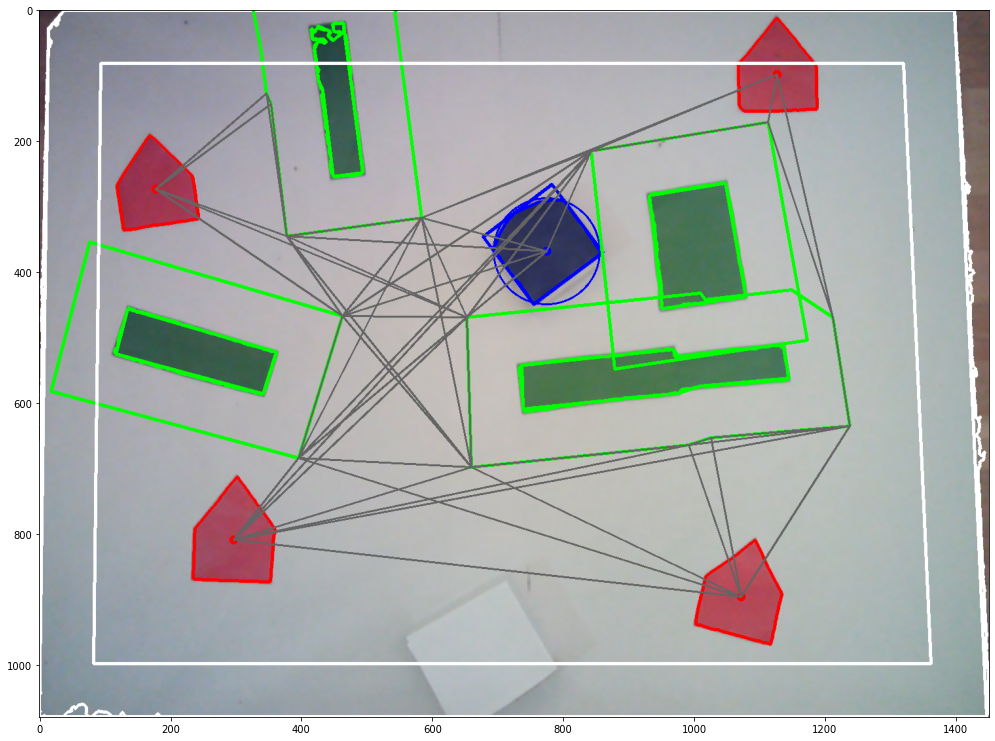

In [11]:
    show_contours = True
    show_polygones = True
    show_dilated_polygones = True
    show_visibility_graph = True
    show_option = [show_contours, show_polygones, show_dilated_polygones, show_visibility_graph]
    
    frame = cv.imread('Thymio_images/raw_map.jpg')
    thymio_state,targets_list,obstacles_list,dilated_obstacle_list,dilated_map, frame_limits, convert_px_mm = object_detection(frame)
    bounded_frame = frame[frame_limits[0]: frame_limits[1], frame_limits[2]: frame_limits[3]]
    visibility_graph,start_idx,targets_idx_list,vertices = vis_graph([thymio_state[0], thymio_state[1]],targets_list,obstacles_list,dilated_obstacle_list,dilated_map)
    modified_frame, thymio_state, thymio_visible = draw_analyze_frame(bounded_frame, show_option, dilated_obstacle_list, dilated_map, visibility_graph, vertices)
    
    modified_frame_rgb = cv.cvtColor(modified_frame, cv.COLOR_BGR2RGB)
    
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [26, 13]
    plt.imshow(modified_frame_rgb)
    plt.show()
    

### Sources :
[1] Caleiro, P. M. R., Neves, A. J. R., & Pinho, A. J. (2007). Color-spaces and color segmentation for real-time object recognition in robotic applications. 4, 6.

[2] Tracking white color using python opencv. (n.d.). NewbeDEV. Retrieved December 9, 2021, from https://newbedev.com

[3] The Shapely User Manual—Shapely 1.8.0 documentation. (n.d.). Retrieved December 9, 2021, from https://shapely.readthedocs.io/en/stable/manual.html

### Conclusion

Combining all the modules helped Santo to save Christmas ! Just run the cell below to see the result !

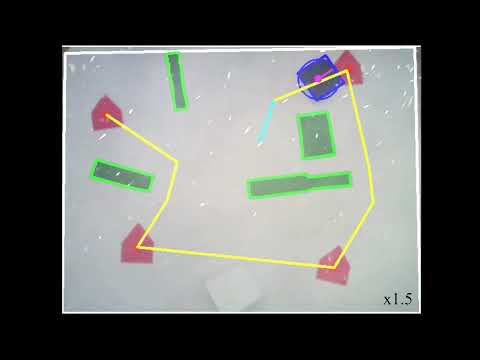

In [12]:
from IPython.display import YouTubeVideo
santo_christmas_hero = YouTubeVideo('50Xt3Dh3GrM')
display(santo_christmas_hero)